STEP 1 PREDICTIONS

In [ ]:
#Time recording
import datetime
startLSTM = datetime.datetime.now()

#Library list
import keras
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
import pandas as pd
import tensorflow
import yfinance as yf
from sklearn import preprocessing
import matplotlib.pyplot as plt
#Set random parameter
np.random.seed(4)
tensorflow.random.set_seed(4)

# Get the data for the stock MSFT between '2012-02-01' to '2019-03-05'
df = yf.download('MSFT','2012-02-01','2019-03-05')
next_day_closed = df['Close'].shift(-1, axis=0)
next_day_closed.drop(index=next_day_closed.index[len(next_day_closed)-1], axis=0, inplace=True)
df.drop(index=df.index[len(df)-1], axis=0, inplace=True)
date = df.index
df.reset_index(drop=True, inplace=True)
df.tail()
open_values=df['Open'].to_numpy()
closed_values=df['Close'].to_numpy()
date_values=date.to_numpy()

#convert as an array will be used as feature in classifier
data = df.to_numpy()
#convert next closed data to array, will be used as label
next_day_closed_values=next_day_closed.to_numpy()
# dataset split and number of rows (history) involved in prediction
test_split = 0.5
history_points=100

#normalized data
data_normaliser = preprocessing.MinMaxScaler()
#data=data.reshape(-1, 1)
data_normalised = data_normaliser.fit_transform(data)
next_day_closed_values = next_day_closed_values.reshape(-1, 1)
next_day_closed_values_normalised = data_normaliser.fit_transform(next_day_closed_values)

data_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
n = 1558#int(data_histories_normalised.shape[0] * test_split)
next_day_closed_values_normalised = np.array([next_day_closed_values_normalised[i + history_points].copy() for i in range(len(next_day_closed_values_normalised) - history_points)])
next_day_closed_values = np.array([next_day_closed_values[i + history_points].copy() for i in range(len(next_day_closed_values) - history_points)])
open_values = np.array([open_values[i + history_points].copy() for i in range(len(open_values) - history_points)])
closed_values= np.array([closed_values[i + history_points].copy() for i in range(len(closed_values) - history_points)])
date_values= np.array([date_values[i + history_points].copy() for i in range(len(date_values) - history_points)])

#TRAIN DATA
data_train = data_histories_normalised[:n]
y_train = next_day_closed_values_normalised[:n]

#TEST DATA
data_test = data_histories_normalised[n:]
y_test = next_day_closed_values_normalised[n:]

unscaled_y_test = next_day_closed_values[n:]
unscaled_y=next_day_closed_values
stacking = pd.DataFrame(columns=['date_time','open', 'close','delta_next_day', 'nextclose'])
stacking['date_time'] = date_values
stacking['open'] = open_values
stacking['close'] = closed_values
stacking['nextclose'] = next_day_closed


#lr=[0.001, 0.005, 0.0005,0.0001, 0.00001]
lr=0.0001
#LSTM MODEL
scaled_mse=0
mse_=0
nb_prediction=50
print('Stacking stage:')
for ii in range(nb_prediction):
    # model architecture
    lstm_input = Input(shape=(history_points, 6), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(1, name='dense_1')(x)
    output = Activation('linear', name='linear_output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(learning_rate=ii*lr+lr)
    model.compile(optimizer=adam, loss='mse')
    #print(len(data_train))
    #print(len(y_train))

    model.fit(x=data_train, y=y_train, batch_size=32, epochs=25, shuffle=True, validation_split=0.1)

    # evaluation
    y_test_predicted = model.predict(data_test)
    y_test_predicted = data_normaliser.inverse_transform(y_test_predicted)
    y_predicted = model.predict(data_histories_normalised)
    y_predicted = data_normaliser.inverse_transform(y_predicted)
    unscaled_y_test = np.reshape(unscaled_y_test, (-1, 1))
    #   print(unscaled_y_test.shape)
 #   print(y_test_predicted.shape)

    assert unscaled_y_test.shape == y_test_predicted.shape
    #real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
    #mse=real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
    #scaled_mse = scaled_mse+real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
    print("Prediction: ",ii)
    #print('MSE:',tf.keras.losses.MSE(tf.expand_dims(srcTF, axis=-1) , tf.expand_dims(tgtTF, axis=-1)) )

    plt.gcf().set_size_inches(22, 15, forward=True)
    start = 0
    end = -1
    #real = plt.plot(unscaled_y_test[start:end], label='real')
    #pred = plt.plot(y_test_predicted[start:end], label='predicted')
    #real = plt.plot(unscaled_y[start:end], label='real')
    #pred = plt.plot(y_predicted[start:end], label='predicted')
    #plt.legend(['Real', 'Predicted'])
    #plt.show()
    #from datetime import datetime
    #model.save(f'basic_model.h5')

    #If next_day_closed_price is higher than today closed price for given threshold, then long or buy
    #If the difference is negative, short or sell, otherwise hold.
    thresh = 0.1
    hold_=0
    long_=1
    short_=2
    strategy=[]
    closed_price_today=[]
    for i in range (len(unscaled_y)):
        closed_price_today_=unscaled_y[i]
        closed_price_today.append(closed_price_today_)
        predicted_closed_price_tomorrow = y_predicted[i]
        delta=predicted_closed_price_tomorrow-closed_price_today_
        if delta > thresh:
            strategy.append(long_)
        elif delta < 0:
            strategy.append(short_)
        else:
            strategy.append(hold_)
    mse=mean_squared_error(next_day_closed_values, y_predicted)
    mse_=mse_+mse
    pt = datetime.datetime.now()-startLSTM
    total_seconds = pt.total_seconds()
    print('Step 1. Number_of_prediction: ',(ii+1),' Average_MSE: ',mse_/(ii+1),' Execution_time (s): ',total_seconds," Learning_rate:", ii*lr+lr)
    S='prediction_'+str(ii)
    stacking[S] = strategy
    print(datetime.datetime.now()-startLSTM)

stacking['delta_next_day'] = next_day_closed_values-y_predicted
stacking['nextclose']=y_predicted#stacking.drop['nextclose'], axis=1, inplace=True)
stacking.to_csv('LSTMs.csv')

endLSTM = datetime.datetime.now()
stackingTime=endLSTM-startLSTM
#print("Execution time: ",stackingTime)
#print("MSE: ",mse_/nb_prediction)

today = plt.plot(next_day_closed_values, label='Tomorrow')
tomorrow = plt.plot(y_predicted, label='Tomorrow_Predicted')
plt.legend(['Tomorrow', 'Tomorrow_Predicted_CNNs'])

plt.show()



STEP 2 RL LEARNER

In [1]:
#Split
import pandas as pd
df_ = pd.read_csv('LSTMs.csv')
df_1=df_.head(1558)
n=len(df_)-1558
df_2=df_[-n:]
df_1.to_csv('LSTMs_train.csv')
df_2.to_csv('LSTMs_test.csv')

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\USER\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Input for RL agent
#in1 number of actions ---in1
#in2: probability of performing explorations ---in2
#in3: initializer ---in3
#in4: folder name where experiments results will be written ---in4
#in5: optimizer ---in5  
#example: 3 0.3 relu teste-adam-0.3-relu  adam  
in1='3'
in2='0.5'
in3='tanha'
in4='LSTMs'
in5='adadelta'

In [3]:
#hold 0..long 1..short 2
#Calculating the metrics
from rl.callbacks import Callback
class ValidationCallback(Callback):
    def __init__(self):
        #Initially, the metrics are zero
        self.episodes = 0
        self.rewardSum = 0
        self.accuracy = 0
        self.coverage = 0
        self.short = 0
        self.long = 0
        self.shortAcc =0
        self.longAcc =0
        self.longPrec =0
        self.shortPrec =0
        self.marketRise =0
        self.marketFall =0
    def reset(self):
        self.episodes = 0
        self.rewardSum = 0
        self.accuracy = 0
        self.coverage = 0
        self.short = 0
        self.long = 0
        self.shortAcc =0
        self.longAcc =0
        self.longPrec =0
        self.shortPrec =0
        self.marketRise =0
        self.marketFall =0
    def on_episode_end(self, action, reward, market):
        self.episodes+=1
        self.rewardSum+=reward
        self.coverage+=1 if (action != 0) else 0
        self.accuracy+=1 if (reward >= 0 and action != 0) else 0
        self.short +=1 if(action == 2) else 0
        self.long +=1 if(action == 1) else 0
        self.shortAcc +=1 if(action == 2 and reward >=0) else 0
        self.longAcc +=1 if(action == 1 and reward >=0) else 0
        if(market>0):
            self.marketRise+=1
            self.longPrec+=1 if(action == 1) else 0
        elif(market<0):
            self.marketFall+=1
            self.shortPrec+=1 if(action == 2) else 0

    def getInfo(self):
        acc = 0
        cov = 0
        short = 0
        long = 0
        longAcc = 0
        shortAcc = 0
        longPrec = 0
        shortPrec = 0
        
        if self.coverage > 0:
            acc = self.accuracy/self.coverage
        if self.episodes > 0:
            cov = self.coverage/self.episodes
            short = self.short/self.episodes
            long = self.long/self.episodes
        if self.short > 0:
            shortAcc = self.shortAcc/self.short
        if self.long > 0:
            longAcc = self.longAcc/self.long
        if self.marketRise > 0:
            longPrec = self.longPrec/self.marketRise
        if self.marketFall > 0:
            shortPrec = self.shortPrec/self.marketFall
        return self.episodes,cov,acc,self.rewardSum,long,short,longAcc,shortAcc,longPrec,shortPrec

In [4]:
#import gym for reinforcement learning
import gym
from gym import spaces
import numpy
import pandas
from datetime import datetime
#import Callback

class SpEnv1(gym.Env):
    continuous = False
    def __init__(self, data, callback = None, ensamble = None, columnName = "iteration-1"):
        self.episode=1
        self.data=data
        self.output=False
        #ensamble is the table of validation and testing
        #If its none, you will not save csvs of validation and testing    
        if(ensamble is not None): # managing the ensamble output (maybe in the wrong way)
            self.output=True
            self.ensamble=ensamble
            self.columnName = columnName
            self.ensamble[self.columnName]=0
        self.low = numpy.array([-numpy.inf])
        self.high = numpy.array([+numpy.inf])
        self.action_space = gym.spaces.Box(low=numpy.array([0]),high= numpy.array([2]), dtype=int)
        self.observation_space = spaces.Box(self.low, self.high, dtype=numpy.float32)
        self.currentObservation = 0
        self.done = False
        self.limit = len(data)      
        self.reward = None
        self.possibleGain = 0
        self.openValue = 0
        self.closeValue = 0
        self.callback=callback

    def step(self, action):
        self.reward=0
        self.possibleGain = self.data.iloc[self.currentObservation]['delta_next_day']
        self.possibleGain = self.data.iloc[self.currentObservation]['delta_next_day']
        if(action == 1):
            self.reward = self.possibleGain
        elif(action==2):
            self.reward = (-self.possibleGain)
        elif(action==0):
            self.reward = 0
        self.done=True
        if(self.callback!=None and self.done):
            self.callback.on_episode_end(action,self.reward,self.possibleGain)
        if(self.output):
            self.ensamble.at[self.data.iloc[self.currentObservation]['date_time'],self.columnName]=action                   
        self.episode+=1   
        self.currentObservation+=1        
        if(self.currentObservation>=self.limit):
            self.currentObservation=0
        return self.getObservation(), self.reward, self.done, {}

    def reset(self): 
        self.done = False
        self.reward = None
        self.possibleGain = 0
        return self.getObservation()

    def getObservation(self):
        predictionList = []
        predictionList=numpy.array(self.data.iloc[self.currentObservation]["prediction_0":"prediction_14"])
        return predictionList.ravel()
    
    def resetEnv(self):
        self.currentObservation=0
        self.episode=1

In [5]:
#Imports the SPEnv library, which will perform the Agent actions themselves
from Callback import ValidationCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import LeakyReLU, PReLU
from keras.optimizers import *
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy
from keras_radam import RAdam
from math import floor
import pandas as pd
import datetime
import os
import numpy
numpy.random.seed(0)

class DeepQTrading1:    
    #Class constructor
    #model: Keras model considered
    #explorations_iterations: a vector containing (i) probability of random predictions; (ii) how many iterations will be 
    #run by the algorithm (we run the algorithm several times-several iterations)  
    #outputFile: name of the file to print metrics of the training
    #ensembleFolderName: name of the file to print predictions
    #optimizer: optimizer to run 
        
    def __init__(self, model, nbActions, explorations_iterations, outputFile, ensembleFolderName, optimizer="adamax"):
        self.ensembleFolderName=ensembleFolderName
        self.policy = EpsGreedyQPolicy()
        self.explorations_iterations=explorations_iterations
        self.nbActions=nbActions
        self.model=model
        #Define the memory
        self.memory = SequentialMemory(limit=10000, window_length=1)
        #Instantiate the agent with parameters received
        self.agent = DQNAgent(model=self.model, policy=self.policy,  nb_actions=self.nbActions, memory=self.memory, nb_steps_warmup=200, target_model_update=1e-1, enable_double_dqn=True,enable_dueling_network=True)
        #Compile the agent with the optimizer given as parameter
        if optimizer=="adamax":        
                self.agent.compile(Adamax(), metrics=['mae'])
        if optimizer=="adadelta":        
                self.agent.compile(Adadelta(), metrics=['mae'])
        if optimizer=="sgd":        
                self.agent.compile(SGD(), metrics=['mae'])
        if optimizer=="rmsprop":        
                self.agent.compile(RMSprop(), metrics=['mae'])
        if optimizer=="nadam":        
                self.agent.compile(Nadam(), metrics=['mae'])
        if optimizer=="adagrad":        
                self.agent.compile(Adagrad(), metrics=['mae'])
        if optimizer=="adam":        
                self.agent.compile(Adam(), metrics=['mae'])
        if optimizer=="radam":        
                self.agent.compile(RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5), metrics=['mae'])

        #Save the weights of the agents in the q.weights file
        #Save random weights
        self.agent.save_weights("q.weights", overwrite=True)
        #Load data
        self.train_data= pd.read_csv('LSTMs_train.csv')#('./dataset/jpm/train_data2.csv')
        self.validation_data=pd.read_csv('LSTMs.csv')#('./dataset/jpm/train_data2.csv')
        self.test_data=pd.read_csv('LSTMs_test.csv')#('./dataset/jpm/test_data2.csv')
                
        #Call the callback for training, validation and test in order to show results for each iteration 
        self.trainer=ValidationCallback()
        self.validator=ValidationCallback()
        self.tester=ValidationCallback()
        self.outputFileName=outputFile

    def run(self):
        #Initiates the environments, 
        trainEnv=validEnv=testEnv=" "
         
        if not os.path.exists(self.outputFileName):
             os.makedirs(self.outputFileName)

        file_name=self.outputFileName+"/LSTMs-agent-training.csv"
        
        self.outputFile=open(file_name, "w+")
        #write the first row of the csv
        self.outputFile.write(
            "Iteration,"+
            "trainAccuracy,"+
            "trainCoverage,"+
            "trainReward,"+
            "trainLong%,"+
            "trainShort%,"+
            "trainLongAcc,"+
            "trainShortAcc,"+
            "trainLongPrec,"+
            "trainShortPrec,"+

            "validationAccuracy,"+
            "validationCoverage,"+
            "validationReward,"+
            "validationLong%,"+
            "validationShort%,"+
            "validationLongAcc,"+
            "validationShortAcc,"+
            "validLongPrec,"+
            "validShortPrec,"+
                
            "testAccuracy,"+
            "testCoverage,"+
            "testReward,"+
            "testLong%,"+
            "testShort%,"+
            "testLongAcc,"+
            "testShortAcc,"+
            "testLongPrec,"+
            "testShortPrec\n")      
        
            
        #Prepare the training and validation files for saving them later 
        ensambleValid=pd.DataFrame(index=self.validation_data[:].loc[:,'date_time'].drop_duplicates().tolist())
        ensambleTest=pd.DataFrame(index=self.test_data[:].loc[:,'date_time'].drop_duplicates().tolist())
            
        #Put the name of the index for validation and testing
        ensambleValid.index.name='date_time'
        ensambleTest.index.name='date_time'
            
        #Explorations are epochs considered, or how many times the agent will play the game.  
        for eps in self.explorations_iterations:

            #policy will use eps[0] (explorations), so the randomness of predictions (actions) will happen with eps[0] of probability 
            self.policy.eps = eps[0]
                
            #there will be 25 iterations or eps[1] in explorations_iterations)
            for i in range(0,eps[1]):
                    
                del(trainEnv)
                #Define the training, validation and testing environments with their respective callbacks
                trainEnv = SpEnv1(data=self.train_data, callback=self.trainer)
                
                del(validEnv)
                validEnv=SpEnv1(data=self.validation_data,ensamble=ensambleValid,callback=self.validator,columnName="iteration"+str(i))
                
                del(testEnv)  
                testEnv=SpEnv1(data=self.test_data, callback=self.tester,ensamble=ensambleTest,columnName="iteration"+str(i))

                #Reset the callback
                self.trainer.reset()
                self.validator.reset()
                self.tester.reset()

                #Reset the training environment
                trainEnv.resetEnv()
                
                #Train the agent
                #The agent receives as input one environment
                self.agent.fit(trainEnv,nb_steps=len(self.train_data),visualize=False,verbose=0)
                
                #Get the info from the train callback    
                (_,trainCoverage,trainAccuracy,trainReward,trainLongPerc,                                              trainShortPerc,trainLongAcc,trainShortAcc,trainLongPrec,trainShortPrec)=self.trainer.getInfo()
                
                print("Iteration " + str(i+1) + " TRAIN:  accuracy: " + str(trainAccuracy)+ " coverage: " + str(trainCoverage)+ " reward: " + str(trainReward))
                             
                #Reset the validation environment
                validEnv.resetEnv()               
                #Test the agent on validation data
                self.agent.test(validEnv,nb_episodes=len(self.validation_data),visualize=False,verbose=0)
                
                #Get the info from the validation callback
                (_,validCoverage,validAccuracy,validReward,validLongPerc,validShortPerc,
validLongAcc,validShortAcc,validLongPrec,validShortPrec)=self.validator.getInfo()
                #Print callback values on the screen
                print("Iteration " +str(i+1) + " VALIDATION:  accuracy: " + str(validAccuracy)+ " coverage: " + str(validCoverage)+ " reward: " + str(validReward))

                #Reset the testing environment
                testEnv.resetEnv()
                #Test the agent on testing data
                self.agent.test(testEnv,nb_episodes=len(self.test_data),visualize=False,verbose=0)
                #Get the info from the testing callback
                (_,testCoverage,testAccuracy,testReward,testLongPerc,testShortPerc,
testLongAcc,testShortAcc,testLongPrec,testShortPrec)=self.tester.getInfo()
                #Print callback values on the screen
                print("Iteration " +str(i+1) + " TEST:  accuracy: " + str(testAccuracy)+ " coverage: " + str(testCoverage)+ " reward: " + str(testReward))
                print(" ")
                    
                #write the metrics in a text file
                self.outputFile.write(
                    str(i)+","+
                    str(trainAccuracy)+","+
                    str(trainCoverage)+","+
                    str(trainReward)+","+
                    str(trainLongPerc)+","+
                    str(trainShortPerc)+","+
                    str(trainLongAcc)+","+
                    str(trainShortAcc)+","+
                    str(trainLongPrec)+","+
                    str(trainShortPrec)+","+
                       
                    str(validAccuracy)+","+
                    str(validCoverage)+","+
                    str(validReward)+","+
                    str(validLongPerc)+","+
                    str(validShortPerc)+","+
                    str(validLongAcc)+","+
                    str(validShortAcc)+","+
                    str(validLongPrec)+","+
                    str(validShortPrec)+","+
                       
                    str(testAccuracy)+","+
                    str(testCoverage)+","+
                    str(testReward)+","+
                    str(testLongPerc)+","+
                    str(testShortPerc)+","+
                    str(testLongAcc)+","+
                    str(testShortAcc)+","+
                    str(testLongPrec)+","+
                    str(testShortPrec)+"\n")

        #Close the file                
        self.outputFile.close()

        if not os.path.exists("./Output/ensemble/"+self.ensembleFolderName):
             os.makedirs("./Output/ensemble/"+self.ensembleFolderName)

        ensambleValid.to_csv("./Output/ensemble/"+self.ensembleFolderName+"/ensemble_valid.csv")
        ensambleTest.to_csv("./Output/ensemble/"+self.ensembleFolderName+"/ensemble_test.csv")


    #Function to end the Agent
    def end(self):
        print("FINISHED")


In [6]:
startLSTM = datetime.datetime.now()
"""""
        python main.py <number_of_actions> <number_of_explorations> <activation> <output_file> <optimizer>        
        ex: python3 main.py 3 0.3 selu teste-rmsprop-0.3-selu rmsprop
        where:
                <number_of_actions>: number of actions done by the agent. 
                <number_of_explorations>: in the RL training, this is the probability that the action taken is random or it obeys the Q-values found previously 
                <activation>: activation function of the double q-network layer we use as RL agent 
                <output_file>: where results will be written 
                <optimizer>: optimization approach of the RL network

       Authors: Anselmo Ferreira, Alessandro Sebastian Podda and Andrea Corriga  
"""""

#os library is used to define the GPU to be used by the code, needed only in cerain situations (Better not to use it, use only if the main gpu is Busy)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";
import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import LeakyReLU, PReLU, ReLU
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy
import sys
import tensorflow as tf
from tensorflow.python.keras import backend as K
config =tf.compat.v1.ConfigProto
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
import random


#There are three actions possible in the stock market
#Hold(id 0): do nothing.
#Long(id 1): It predicts that the stock market value will raise at the end of the day. 
#Short(id 2): It predicts that the stock market value will decrease at the end of the day.

#NN composes one flatten layer to get 1000 dimensional vectors as input
#One dense layer with 35 neurons with a given activation
#One final Dense Layer with the number of actions considered and linear activation

model = Sequential()
model.add(Flatten(input_shape=(1,15))) #10 number of prediction
if(in3=="relu"):
    model.add(Dense(35,activation='relu'))    
if(in3=="sigmoid"):
    model.add(Dense(35,activation='sigmoid'))    
if(in3=="linear"):
    model.add(Dense(35,activation='linear'))
if(in3=="tanh"):
    model.add(Dense(35,activation='tanh'))
if(in3=="selu"):
    model.add(Dense(35,activation='selu'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(int(in1)))
model.add(Activation('linear'))



#Define the DeepQTrading class with the following parameters:
dqt = DeepQTrading1(
    model=model,
    nbActions=int(in1),
    explorations_iterations=[(round(float((in2))),25)],
    outputFile="./Output/csv/" + in4,
    ensembleFolderName=in4,
    optimizer=in5
    )

dqt.run()
dqt.end()
pt = datetime.datetime.now()-startLSTM
total_seconds = pt.total_seconds()
print('Step 2. LR Learning stage execution_time (s): ',total_seconds)


C:\Users\USER\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Iteration 1 TRAIN:  accuracy: 0.4595635430038511 coverage: 1.0 reward: -46.04576110839844
Iteration 1 VALIDATION:  accuracy: 0.47888161808447355 coverage: 1.0 reward: 106.63872528076172
Iteration 1 TEST:  accuracy: 0.7235772357723578 coverage: 1.0 reward: 152.68448638916016
 
Iteration 2 TRAIN:  accuracy: 0.4595635430038511 coverage: 1.0 reward: -46.04576110839844
Iteration 2 VALIDATION:  accuracy: 0.47888161808447355 coverage: 1.0 reward: 106.63872528076172
Iteration 2 TEST:  accuracy: 0.7235772357723578 coverage: 1.0 reward: 152.68448638916016
 
Iteration 3 TRAIN:  accuracy: 0.4595635430038511 coverage: 1.0 reward: -46.04576110839844
Iteration 3 VALIDATION:  accuracy: 0.47888161808447355 coverage: 1.0 reward: 106.63872528076172
Iteration 3 TEST:  accuracy: 0.7235772357723578 coverage: 1.0 reward: 152.68448638916016
 
Iteration 4 TRAIN:  accuracy: 0.4595635430038511 coverage: 1.0 reward: -46.04576110839844
Iteration 4 VALIDATION:  accuracy: 0.47888161808447355 coverage: 1.0 reward: 10

STEP 3 MAJORITY VOTING AND PLOT

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def majority_voting(df):
    
    local_df = df.copy()
    x=local_df.loc[:,'iteration0':'iteration24']
    local_df['ensemble']=x.mode(axis=1).iloc[:, 0]
    local_df = local_df.drop(local_df.columns.difference(['ensemble']), axis=1)
    return local_df
    
def ensemble(type, ensembleFolderName):

    dollSum=0
    rewSum=0
    posSum=0
    negSum=0
    covSum=0 
    numSum=0

    values=[]
    columns = ["Experiment","#Wins","#Losses","Dollars","Coverage","Accuracy"]
    
    stacking=pd.read_csv("LSTMs_test.csv",index_col='date_time')
      
    df=pd.read_csv("./Output/ensemble/LSTMs/ensemble_"+type+".csv",index_col='date_time')
        
    df=majority_voting(df)
      
    num=0
    rew=0
    pos=0
    neg=0
    doll=0
    cov=0

  
    #Lets iterate through each date and decision 
    for date, i in df.iterrows():
     
        #If the date in the predictions is in the index of stacking (which is also a date) 
        if date in stacking.index:
             
            num+=1
              
            #If the output is 1 (long)
            if (i['ensemble']==1):
                   
                #If the close - open is positive at that day, we have earning money. Positives are equal to 1. Otherwise, no incrementation 
                pos+= 1 if (float(stacking.at[date,'delta_next_day'])) > 0 else 0

                #If close - open is negative at that day, we are losing money. Negatives are equal to 1. Otherwise, no incrementation 
                neg+= 1 if (float(stacking.at[date,'delta_next_day'])) < 0 else 0

                #Lets calculate the reward (positive or negative)
                rew+=float(stacking.at[date,'delta_next_day'])
                    
                #In dollars, we just multiply by the stacking points by the differences 
                doll+=float(stacking.at[date,'delta_next_day'])

                #There is coverage (of course) 
                cov+=1

            #The same stuff happens for short.
            elif (i['ensemble']==2):
     
                pos+= 1 if float(stacking.at[date,'delta_next_day']) < 0 else 0
                neg+= 1 if float(stacking.at[date,'delta_next_day']) > 0 else 0
                    
                rew+=-float(stacking.at[date,'delta_next_day'])
                cov+=1
                doll+=-float(stacking.at[date,'delta_next_day'])
                    


    values.append([str(1),str(round(pos,2)),str(round(neg,2)),str(round(doll,2)),str(round(cov/num,2)),(str(round(pos/cov,2)) if (cov>0) else "")])
        
    #Now lets sum walk by walk 
    dollSum+=doll
    rewSum+=rew
    posSum+=pos
    negSum+=neg
    covSum+=cov
    numSum+=num

    
    #Now lets summarize everything showing the sum of values 
    values.append(["sum",str(round(posSum,2)),str(round(negSum,2)),str(round(dollSum,2)),str(round(covSum/numSum,2)),(str(round(posSum/covSum,2)) if (covSum>0) else "")])
    
    return values,columns
    
    
################


Test acuracy:  0.7235772357723578
Train acuracy:  0.4595635430038511
Validation acuracy:  0.4788816180844735
Test LongAcc:  0.7235772357723578
Train LongAcc:  0.4595635430038511
Validation LongAcc:  0.4788816180844735
Test ShortAcc:  0
Train ShortAcc:  0
Validation ShortAcc:  0
Test Coverage:  1.0
Train Coverage:  1.0
Validation Coverage:  1.0
Test Reward:  152.68448638916016
Train Reward:  -46.04576110839844
Validation Reward:  106.63872528076172
Step 3. Majority voting stage execution_time (s):  0.65002


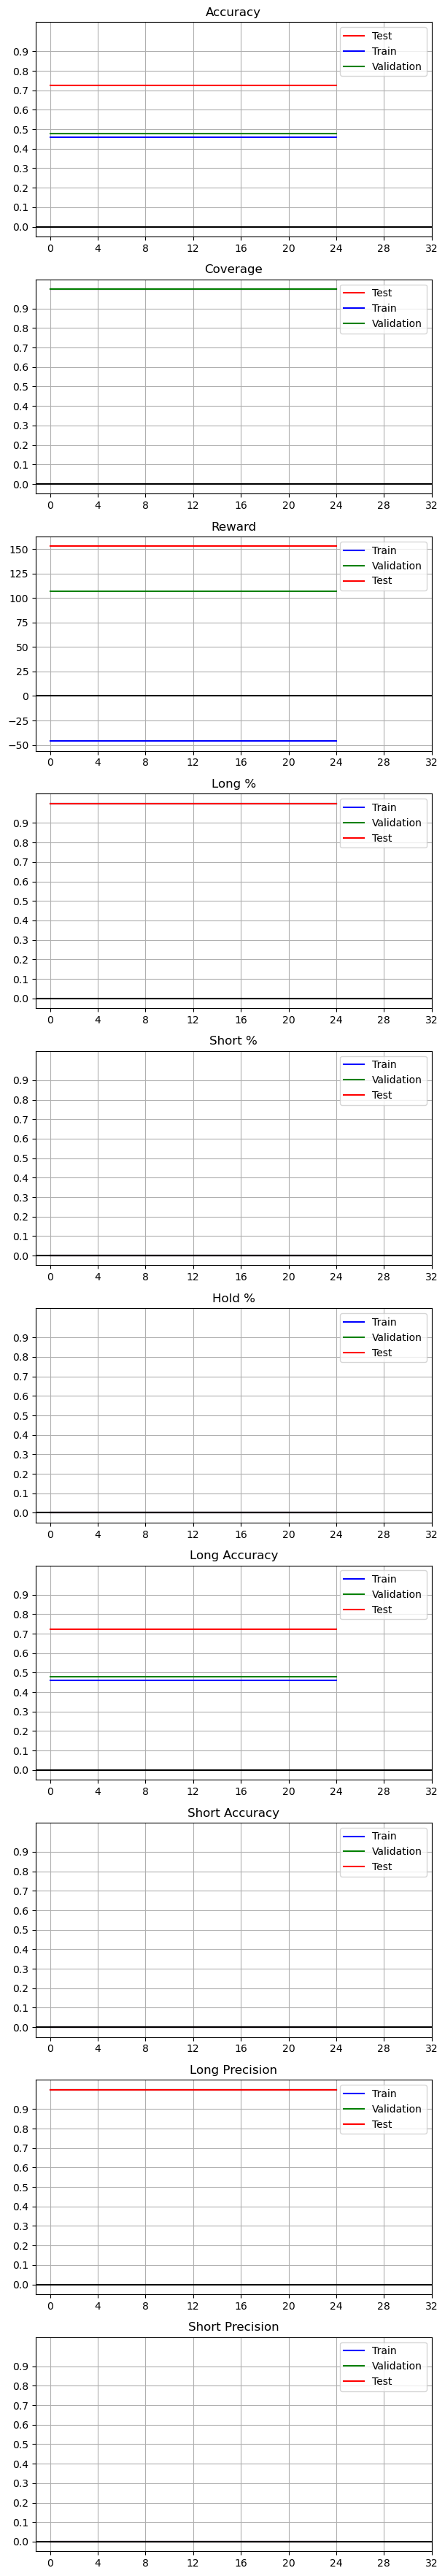

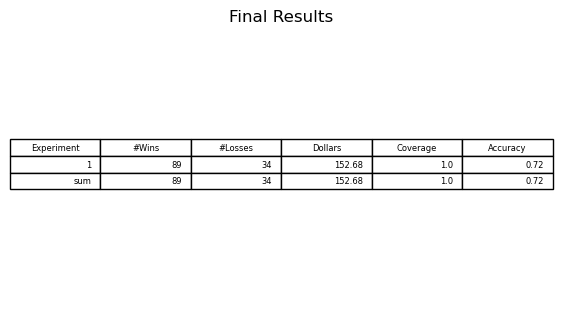

In [8]:
startLSTM = datetime.datetime.now()

from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from math import floor
#from ensemble import ensemble
from matplotlib.gridspec import GridSpec

#sys.argv[1] --input1
#sys.argv[2] --input2
#sys.argv[3] --input3
#sys.argv[4] --input4
input1='teste-adam-0.3-relu'
input2='results-adam-relu-explorations-0.3'
input3='1'
input4='0'

outputFile=str(input2)+".pdf"
numFiles=int(input3)
#Number of epochs in the algorithm
numEpochs=35
numPlots=10

pdf=PdfPages(outputFile)

#Configure the size of the picture that will be plotted
#Configure the size of the picture that will be plotted
plt.figure(figsize=((numEpochs/10)*(2),9*5))

#Open the file that was saved on folder csv/walks, containing information about each iteration in that walk 
#Lets show a summary of each walk
#For each walk, one column is plotted in a final pdf file

doc = pd.read_csv("Output/csv/LSTMs/LSTMs-agent-training.csv")

a_test=(doc.loc[:, 'testAccuracy'])[1]
print('Test acuracy: ',a_test)
a_train=(doc.loc[:, 'trainAccuracy'])[1]
print('Train acuracy: ',a_train)
a_val=(doc.loc[:, 'validationAccuracy'])[1]
print('Validation acuracy: ',a_val)
      
a_test=(doc.loc[:, 'testLongAcc'])[1]
print('Test LongAcc: ',a_test)
a_train=(doc.loc[:, 'trainLongAcc'])[1]
print('Train LongAcc: ',a_train)
a_val=(doc.loc[:, 'validationLongAcc'])[1]
print('Validation LongAcc: ',a_val)
      
a_test=(doc.loc[:, 'testShortAcc'])[1]
print('Test ShortAcc: ',a_test)
a_train=(doc.loc[:, 'trainShortAcc'])[1]
print('Train ShortAcc: ',a_train)
a_val=(doc.loc[:, 'validationShortAcc'])[1]
print('Validation ShortAcc: ',a_val)
      
a_test=(doc.loc[:, 'testCoverage'])[1]
print('Test Coverage: ',a_test)
a_train=(doc.loc[:, 'trainCoverage'])[1]
print('Train Coverage: ',a_train)
a_val=(doc.loc[:, 'validationCoverage'])[1]
print('Validation Coverage: ',a_val)
      
a_test=(doc.loc[:, 'testReward'])[1]
print('Test Reward: ',a_test)
a_train=(doc.loc[:, 'trainReward'])[1]
print('Train Reward: ',a_train)
a_val=(doc.loc[:, 'validationReward'])[1]
print('Validation Reward: ',a_val)

for i in range(1,numFiles+1):

    document = pd.read_csv("Output/csv/LSTMs/LSTMs-agent-training.csv")
    plt.subplot(numPlots,numFiles,0*numFiles + i)
    #Draw information in that file. First of all, lets plot accuracy
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testAccuracy'].tolist(),'r',label='Test')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainAccuracy'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationAccuracy'].tolist(),'g',label='Validation')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')

    #Lets draw information about coverage, read from the csv file located at csv/walks
    plt.subplot(numPlots,numFiles,1*numFiles + i)
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testCoverage'].tolist(),'r',label='Test')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainCoverage'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationCoverage'].tolist(),'g',label='Validation')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Coverage')

    # Information about reward
    plt.subplot(numPlots,numFiles,2*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainReward'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationReward'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testReward'].tolist(),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Reward')
    
    #Percentages of long
    plt.subplot(numPlots,numFiles,3*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainLong%'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationLong%'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testLong%'].tolist(),'r',label='Test')  
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))    
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Long %')
    
    #Percentages of short
    plt.subplot(numPlots,numFiles,4*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainShort%'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationShort%'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testShort%'].tolist(),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Short %')
    

    #Coverage
    plt.subplot(numPlots,numFiles,5*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),list(map(lambda x: 1-x,document.loc[:, 'trainCoverage'].tolist())),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),list(map(lambda x: 1-x,document.loc[:, 'validationCoverage'].tolist())),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),list(map(lambda x: 1-x,document.loc[:, 'testCoverage'].tolist())),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Hold %')
    

    #Accuracy of longs
    plt.subplot(numPlots,numFiles,6*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainLongAcc'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationLongAcc'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testLongAcc'].tolist(),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Long Accuracy')
    
    #Accuracy of shorts
    plt.subplot(numPlots,numFiles,7*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainShortAcc'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validationShortAcc'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testShortAcc'].tolist(),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Short Accuracy')

    
    #Precisions of long
    plt.subplot(numPlots,numFiles,8*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainLongPrec'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validLongPrec'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testLongPrec'].tolist(),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Long Precision')
    
    #Precisions of short
    plt.subplot(numPlots,numFiles,9*numFiles + i )
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'trainShortPrec'].tolist(),'b',label='Train')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'validShortPrec'].tolist(),'g',label='Validation')
    plt.plot(document.loc[:, 'Iteration'].tolist(),document.loc[:, 'testShortPrec'].tolist(),'r',label='Test')
    plt.xticks(range(0,numEpochs,4))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.ylim(-0.05,1.05)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.legend()
    plt.grid()
    plt.title('Short Precision')

pt = datetime.datetime.now()-startLSTM
total_seconds = pt.total_seconds()
print('Step 3. Majority voting stage execution_time (s): ',total_seconds)

#plt.suptitle("Experiment RL metalearner 35 neurons single layer",size=19,weight=20,ha='left',x=0.1,y=0.99)

pdf.savefig()


#Now, lets try the ensemble
i=1

###########-------------------------------------------------------------------|Tabella Full Ensemble|-------------------
x=2
y=1
plt.figure(figsize=(x*3.5,y*3.5))

plt.subplot(y,y,1)
plt.axis('off')
val,col=ensemble("test", input1)
t=plt.table(cellText=val, colLabels=col, fontsize=20, loc='center')
t.auto_set_font_size(False)
t.set_fontsize(6)
plt.title("Final Results")
#plt.suptitle("MAJORITY VOTING")
pdf.savefig()
###########--------------------------------------------------------------------------------------------------------------------
pdf.close()